Group name: PUBG
--
Group members: Min Che, Peng Liu, Xuxu Pan

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn import metrics
import seaborn as sns
from rfpimp import *

# Project Goal

The goal of this project is to predict the finish placement of the PlayerUknown’s BattleGrounds(PUBG) players.

## 1. Load Data

### Please refer to this link to download the data if the train_V2.csv in the repo doesn't show properly:  
https://www.kaggle.com/c/pubg-finish-placement-prediction/download/train_V2.csv


### Data Description

- Data source: https://www.kaggle.com/c/pubg-finish-placement-prediction/data
- Target：winPlacePerc, player’s percentile in one game (float, 0 to 1).
- Number of observations: >4 M, each row contains a player's post-game stats.
- Number of raw features: 28, including player’s stats such as assists, boosts, damage, kills, player per match, - player per group, walk distance...

In [2]:
data = pd.read_csv('train_V2.csv')

In [3]:
data.head(2).T

,0,1
Id,7f96b2f878858a,eef90569b9d03c
groupId,4d4b580de459be,684d5656442f9e
matchId,a10357fd1a4a91,aeb375fc57110c
assists,0,0
boosts,0,0
damageDealt,0,91.47
DBNOs,0,0
headshotKills,0,0
heals,0,0
killPlace,60,57


## 2. Process Data

We added 2 new features: player per match by counting the match ids and player per group by counting the group ids.

To eliminate possible outliers, we dropped matches that have less than 80 players or have group with more than 4 players. 

We also down sample the data to 165 thousand rows and dropped 4 highly related features.

Finally, we made a train-validation-test split.

#### (1) Get the number of user per match and merge it to the orginal dataset

In [4]:
player_per_match = data.groupby('matchId').count()[['Id']].reset_index()
player_per_match.columns = ['matchId','player_per_match']
data_new = data.merge(player_per_match, on='matchId', how='left')

In [5]:
data_new.head(5)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,player_per_match
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0.0000,0,0.00,0,0,244.80,1,1466,0.4444,96
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0.0045,0,11.04,0,0,1434.00,5,0,0.6400,91
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0.0000,0,0.00,0,0,161.80,2,0,0.7755,98
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0.0000,0,0.00,0,0,202.70,3,0,0.1667,91
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0.0000,0,0.00,0,0,49.75,2,0,0.1875,97


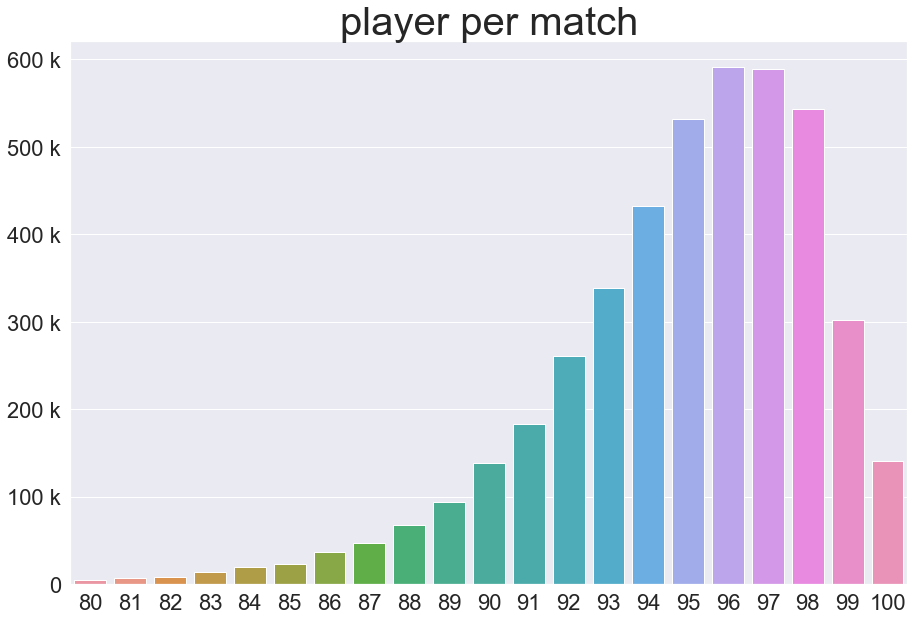

In [6]:
plt.figure(figsize=(15,10))
sns.set(font_scale=2)
player_match = sns.countplot(data_new.loc[data_new['player_per_match']>=80]['player_per_match'])
player_match.axes.set_title("player per match", fontsize=40)
player_match.set_xlabel('') 
player_match.set_ylabel('')
player_match.yaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

#### (2) Get the number of user per group and merge it to the original dataset

In [7]:
group_info = data.groupby(['matchId','groupId']).count()[['Id']].reset_index()
group_info.columns = ['matchId', 'groupId', 'player_per_group']

In [8]:
data_new = data_new.merge(group_info, on=['matchId','groupId'], how='left')

In [9]:
data_new.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,player_per_match,player_per_group
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0.00,0,0,244.80,1,1466,0.4444,96,4
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,0,11.04,0,0,1434.00,5,0,0.6400,91,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0.00,0,0,161.80,2,0,0.7755,98,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,0,0.00,0,0,202.70,3,0,0.1667,91,1
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0.00,0,0,49.75,2,0,0.1875,97,1
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,...,0,0.00,0,0,34.70,1,0,0.0370,95,10
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,...,0,0.00,0,0,13.50,1,1497,0.0000,97,6
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,0.00,0,0,1089.00,6,1500,0.7368,96,1
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,...,0,0.00,0,0,799.90,4,0,0.3704,97,3
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,...,0,0.00,0,0,65.67,1,0,0.2143,97,3


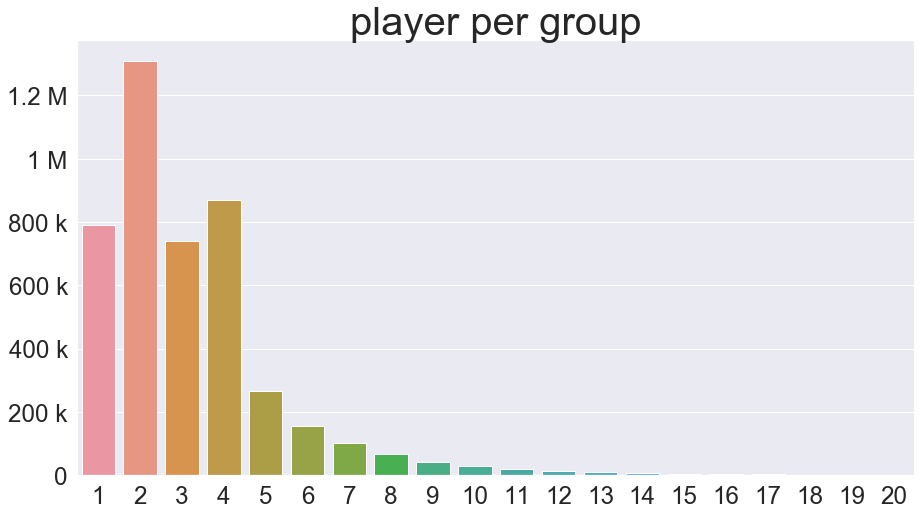

In [10]:
plt.figure(figsize=(15,8))
sns.set(font_scale=2.2)
player_group = sns.countplot(data_new[data_new.player_per_group <= 20]['player_per_group'])
player_group.axes.set_title("player per group", fontsize=40)
player_group.set_xlabel('') 
player_group.set_ylabel('')
player_group.yaxis.set_major_formatter(ticker.EngFormatter())
plt.show()

#### (3) Eliminate those matches that are not normal match type

Normal match type: over 80 players per match, less than 5 players per group

In [11]:
# Select matches with less than 80 players
match_less_than_80 = list(data_new.loc[data_new['player_per_match']<80]['matchId'])
# Select groups with more than 4 players
match_group_not_use = list(data_new.loc[~data_new['player_per_group'].isin([1,2,3,4])]['matchId'])

In [12]:
lst = match_less_than_80 + match_group_not_use

In [13]:
data_dropped = data_new.loc[~data_new['matchId'].isin(lst)]

In [14]:
data_dropped['player_per_match'].unique()

array([ 97,  96,  95,  93,  92,  91,  94,  99,  90,  98,  88, 100,  84,
        89,  80,  81,  86,  85,  87,  82,  83])

In [15]:
data_dropped['player_per_group'].unique()

array([1, 2, 3, 4])

In [16]:
data_dropped.shape

(1647723, 31)

#### (4) Encode groupId as numbers

In [17]:
le = preprocessing.LabelEncoder()
le.fit(data_dropped['groupId'])
data_dropped['groupIdNum'] = le.fit_transform(data_dropped['groupId'])

/opt/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
data_dropped.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,player_per_match,player_per_group,groupIdNum
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0.00,0,0,49.75,2,0,0.1875,97,1,987158
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0.00,0,0,1089.00,6,1500,0.7368,96,1,1043489
13,b7807186e3f679,3c08e461874749,2c30ddf481c52d,0,1,324.200,0,1,5,5,...,76.84,0,0,2050.00,6,1462,0.8750,97,1,267906
15,12d8d4bd94312c,fe52d481bae68b,6fd9e765ddd0c5,0,0,80.710,1,0,0,72,...,0.00,0,0,105.10,5,0,0.2766,95,2,1131040
17,92022479b92ce7,2f2c33f548c4b9,07948d723b9c0f,0,3,254.300,0,0,12,13,...,15.29,0,0,1787.00,3,0,0.8211,96,1,210407


**(5) Down Sampling**

In [19]:
len(data_dropped.matchId.unique())

17368

In [20]:
def downsample(df, r):
    matchid = df.matchId.unique()
    size = int(len(matchid)*r)
    choice = np.random.choice(matchid, size = size, replace=False)
    df = df[df.matchId.isin(choice)]
    return df

In [21]:
PUBG = downsample(data_dropped, 0.1)
PUBG.shape

(164757, 32)

#### (6) Set X and y and make train-validation-test split

In [22]:
#Split train, test, validation set by randomly choosing match ID
def split(df, r):
    matchid = df.matchId.unique()
    size = int(len(matchid)*r)
    choice = np.random.choice(matchid, size = size, replace=False)
    df_test = df[df.matchId.isin(choice)]
    df_train = df[~df.matchId.isin(choice)]
    return df_train,df_test

In [23]:
# 'rankPoints', 'killPoints' are highly correlated with 'winPoints', 'maxPlace' is highly correlated with 'numGroup'.
def drop(df):
    y = df['winPlacePerc'].values.ravel()
    X = df.drop(['winPlacePerc'], axis=1)
    X = X.drop(['Id', 'groupId', 'matchId', 'matchType','rankPoints', 'killPoints', 'maxPlace'], axis=1)
    return X,y

In [24]:
train, test = split(PUBG, 0.3)

In [25]:
train_train, train_valid = split(train, 0.3)

In [26]:
X_train, y_train = drop(train)
X_test, y_test = drop(test)

In [27]:
X_train_train, y_train_train = drop(train_train)
X_train_valid, y_train_valid = drop(train_valid)

## 3. Model

For model selection, we made a pipeline to fit 3 models: linear regression without tuning as our baseline, decision tree and random forest, with hyperparameters tuned by randomized search CV.

### (1) Hyperparameter Tuning: RandomizedSearchCV

**Random Forest**

In [28]:
cv=5
n_iter=20

def make_random_cv_rf():
    
    param_dist = {"max_features":["auto","sqrt","log2", None],
                  "n_estimators":np.arange(start=50,stop=300,step=10),
                  "min_samples_split": np.arange(start=2,stop=20,step=2),
                  "min_samples_leaf": np.arange(start=1,stop=50,step=5),
                  "max_depth": [3, 4, 5, 6, 7, 8, 9,10,None],
                  "bootstrap": [True, False]
                 }
    clf_random_cv = RandomizedSearchCV(RandomForestRegressor(random_state=42), 
                                       param_distributions=param_dist,
                                       cv=cv, 
                                       n_iter=n_iter, 
                                       verbose=1)
    return clf_random_cv

In [29]:
rf_random_cv = make_random_cv_rf()

In [30]:
# Comment out the RandomizedSearchCV fitting to save running time
# Search Output has been recorded below
# rf_random_cv.fit(X_train_train, y_train_train)

In [31]:
# Record the best hyperparameters
para_rf = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 31,
 'min_samples_split': 16,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 220,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False,
 'random_state':42}

**Decision Tree**

In [32]:
cv=5
n_iter=20

def make_random_cv_dt():
    
    param_dist = {"max_features":["auto","sqrt","log2", None],
                  "min_samples_split": np.arange(start=2,stop=20,step=2),
                  "min_samples_leaf": np.arange(start=1,stop=50,step=5),
                  "max_depth": [3, 4, 5, 6, 7, 8, 9,10,None]}
    
    clf_random_cv = RandomizedSearchCV(DecisionTreeRegressor(random_state=42), 
                                       param_distributions=param_dist,
                                       cv=cv, 
                                       n_iter=n_iter, 
                                       verbose=1)
    return clf_random_cv

In [33]:
dt_random_cv = make_random_cv_dt()

In [34]:
# Comment out the RandomizedSearchCV fitting to save running time
# Search Output has been recorded below
# dt_random_cv.fit(X_train_train, y_train_train)

In [35]:
# Record the best hyperparameters
para_dt = {'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 16,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 42,
 'splitter': 'best',
 'random_state':42}

### (2) make a pipeline to fit 3 models

In [36]:
def make_pipelines():
    pipe_lr = Pipeline([('scl', StandardScaler()),
                        ('lr', LinearRegression())]) #baseline
    pipe_rf = Pipeline([('rf', RandomForestRegressor(**para_rf))])
    pipe_dt = Pipeline([('dt', DecisionTreeRegressor(**para_dt))])
    
    pipelines = [pipe_lr, pipe_rf, pipe_dt]
    
    return pipelines

In [37]:
pipelines = make_pipelines()

In [38]:
for pipe in pipelines:
    pipe.fit(X_train_train, y_train_train)

## 4. Metrics

We evaluated the models with Median Absolute Error and Mean Square Error and chose MedAE as our North Star metrics, for the reason that MedAE is more robust to outliers. 

#### (1) North Star metrics: MedAE

#### Medae of training set

In [39]:
for pipe in pipelines:
    y_pred = pipe.predict(X_train_train)
    medae_value_train = metrics.median_absolute_error(y_train_train, y_pred) 
    print(str(type(pipe[-1])).split(".")[-1][:-2], '\n', medae_value_train)

LinearRegression 
 0.053878354113156335
RandomForestRegressor 
 0.03313627762497562
DecisionTreeRegressor 
 0.028647058823529407


#### Medae of validation set

In [40]:
for pipe in pipelines:
    y_pred = pipe.predict(X_train_valid)
    medae_value_validation = metrics.median_absolute_error(y_train_valid, y_pred) 
    print(str(type(pipe[-1])).split(".")[-1][:-2], '\n', medae_value_validation)

LinearRegression 
 0.05389927866563066
RandomForestRegressor 
 0.03519106905543168
DecisionTreeRegressor 
 0.03663888888888886


#### Medae of test set

In [41]:
for pipe in pipelines:
    y_pred = pipe.predict(X_test)
    medae_value_test = metrics.median_absolute_error(y_test, y_pred) 
    print(str(type(pipe[-1])).split(".")[-1][:-2], '\n', medae_value_test)

LinearRegression 
 0.053947177275490144
RandomForestRegressor 
 0.03508683236833471
DecisionTreeRegressor 
 0.036730769230769234


#### (2) Metrics for comparison: MSE

#### MSE for training set

In [42]:
for pipe in pipelines:
    y_pred = pipe.predict(X_train_train)
    mse_train = metrics.mean_squared_error(y_train_train, y_pred) 
    print(str(type(pipe[-1])).split(".")[-1][:-2], '\n', mse_train)

LinearRegression 
 0.01033426242162816
RandomForestRegressor 
 0.0048976590862873474
DecisionTreeRegressor 
 0.0036608114592822363


#### MSE for validation set

In [43]:
for pipe in pipelines:
    y_pred = pipe.predict(X_train_valid)
    mse_validation = metrics.mean_squared_error(y_train_valid, y_pred) 
    print(str(type(pipe[-1])).split(".")[-1][:-2], '\n', mse_validation)

LinearRegression 
 0.010354376697612754
RandomForestRegressor 
 0.0053653415789577195
DecisionTreeRegressor 
 0.005945565313887115


#### MSE for test set

In [44]:
for pipe in pipelines:
    y_pred = pipe.predict(X_test)
    mse_test = metrics.mean_squared_error(y_test, y_pred) 
    print(str(type(pipe[-1])).split(".")[-1][:-2], '\n', mse_test)

LinearRegression 
 0.01023600470705777
RandomForestRegressor 
 0.005355748740649857
DecisionTreeRegressor 
 0.005853417874759092


## 5. Results and visualization

#### (1) Result of model selection

In [45]:
# Transfer the medae of training set and validation set to dataframe
def to_df(pipelines):
    model = []
    medae_train = []
    medae_val = []
    for pipe in pipelines:
        y_pred_train = pipe.predict(X_train_train)
        y_pred_val = pipe.predict(X_train_valid)
        model.append(str(type(pipe[-1])).split(".")[-1][:-2])
        medae_train.append(metrics.median_absolute_error(y_train_train, y_pred_train))
        medae_val.append(metrics.median_absolute_error(y_train_valid, y_pred_val))
    df_train = pd.DataFrame(np.array([model, medae_train]).T, columns = ['model', 'medae'])
    df_train['flag'] = 'train'
    df_val = pd.DataFrame(np.array([model, medae_val]).T, columns = ['model', 'medae'])
    df_val['flag'] = 'validation'
    df = pd.concat([df_train, df_val])
    return df

In [46]:
model_selection = to_df(pipelines)

In [47]:
model_selection['medae'] = model_selection['medae'].astype('float')

In [48]:
model_selection

,model,medae,flag
0,LinearRegression,0.053878,train
1,RandomForestRegressor,0.033136,train
2,DecisionTreeRegressor,0.028647,train
0,LinearRegression,0.053899,validation
1,RandomForestRegressor,0.035191,validation
2,DecisionTreeRegressor,0.036639,validation


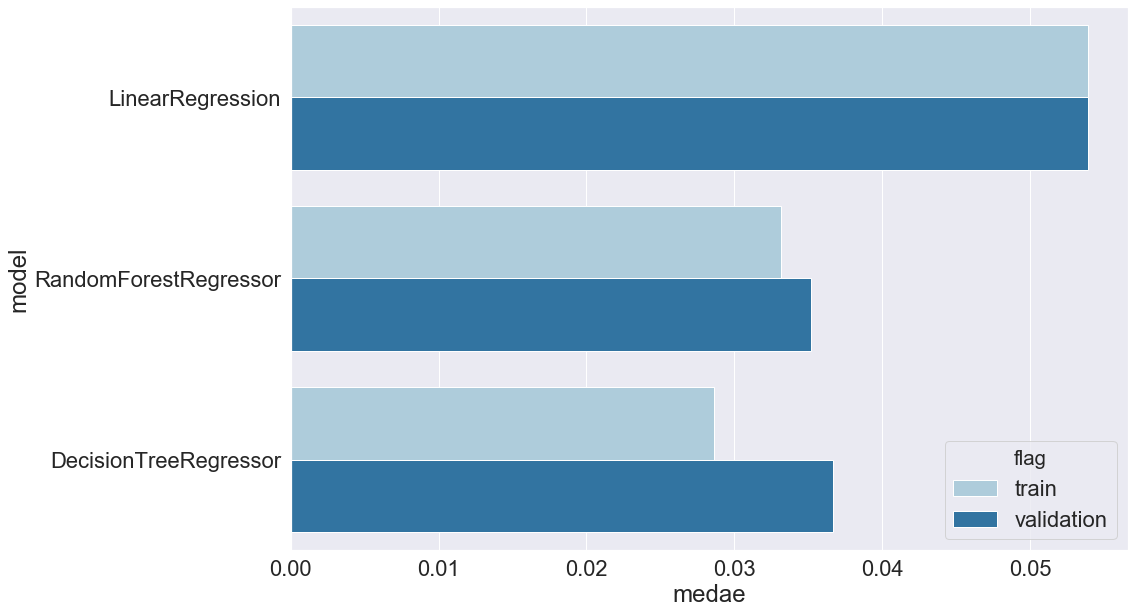

In [49]:
plt.figure(figsize=(15, 10))
sns.set(font_scale=2)
plt_model_selection = sns.barplot(
    y="model", x='medae', hue='flag', data=model_selection, palette='Paired')

Random Forest model performs the best among these 3 models on validation set. Decision Tree model performs pretty well on the training set, but much worse on the validation set, meaning that it is a bit overfitted.
So we chose the Random Forest model as our final model.

So we chose the Random Forest model as our final model.

#### (2) Result of feature importance

In [50]:
y_train_df = pd.DataFrame(y_train)
# Get the feature importance from the rfimp package
I = importances(pipelines[1].steps[0][1], X_train, y_train_df)
feature_imp = I.reset_index()

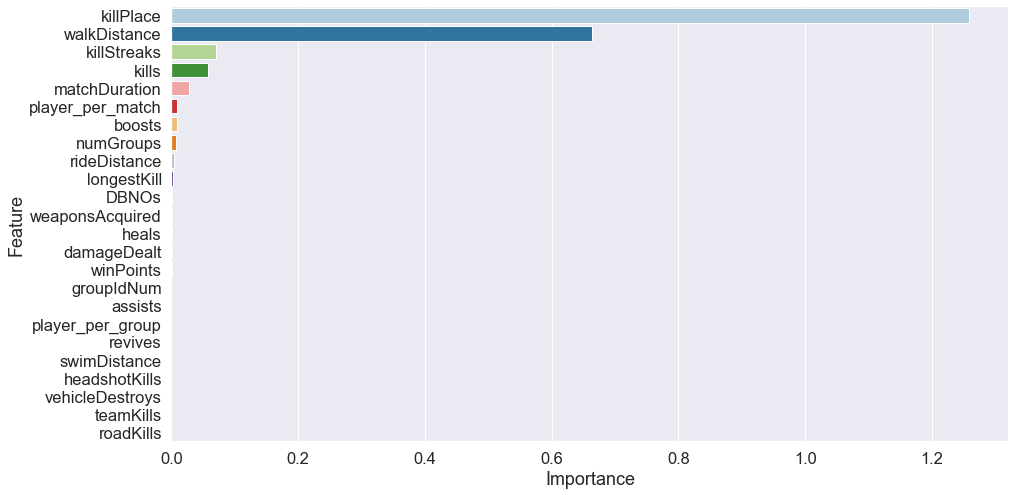

In [51]:
# Plot results
plt.figure(figsize=(15,8))
sns.set(font_scale=1.5)
plt_feature_imp = sns.barplot(x="Importance", y='Feature', data=feature_imp, palette='Paired')

Random forest model selected about 10 important features out of 24. Top three important features include 'killPlace', 'walkDistance' and 'kills'.

#### (3) Relation of 'winPlacePerc' against 'killplace' 

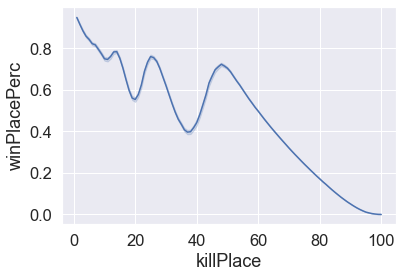

In [52]:
plt_kill_win = sns.lineplot(x="killPlace", y="winPlacePerc", data=PUBG, palette='Paired')

The high ranking in 'killPlace', the higher ranking in 'winPlacePerc'.

#### (4) Relation of  'winPlacePerc' against 'walkDistance'

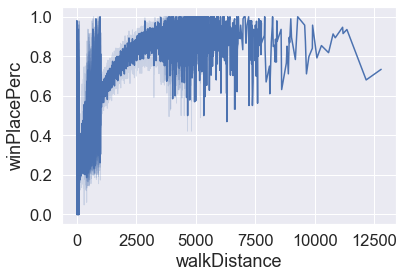

In [53]:
plt_walk_win = sns.lineplot(x="walkDistance", y="winPlacePerc", data=PUBG, palette='Paired')

The players who perform best walk around 5000 to 10000 miles in a match

#### (5) Relation of ''winPlacePerc' against 'kill'

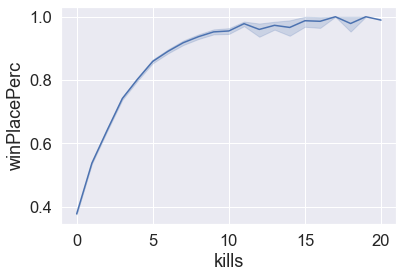

In [54]:
plt_kills_win = sns.lineplot(x="kills", y="winPlacePerc", data=PUBG, palette='Paired')

The more kills, the higher final ranking.

## 6. Select important features and fit the model again

#### (1) Refit the Random Forest model with only important features

In [55]:
# Select features with importance no less than 0.001
features_s = list(feature_imp[feature_imp.Importance >= 0.001].Feature)

In [56]:
# Make training, validation and test set only contain selected features
X_train_train_s = X_train_train[features_s]
X_train_valid_s = X_train_valid[features_s]
X_test_s = X_test[features_s]

In [57]:
rfregressor = RandomForestRegressor(**para_rf)

In [58]:
rfregressor.fit(X_train_train_s, y_train_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=31, min_samples_split=16,
                      min_weight_fraction_leaf=0.0, n_estimators=220,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

#### (2) Evaluation by the North Star metrics

#### Medae of train set

In [60]:
# MedAE of orginal model
y_pred = pipelines[1].steps[0][1].predict(X_train_train)
medae_value_train = metrics.median_absolute_error(y_train_train, y_pred)
# MedAE of refit model
y_pred = rfregressor.predict(X_train_train_s)
medae_value_train_2 = metrics.median_absolute_error(y_train_train, y_pred)
print("MedAE of orginal model:", medae_value_train,"MedAE of refit model", medae_value_train_2)

MedAE of orginal model: 0.03313627762497562 MedAE of refit model 0.03331066754071055


#### Medae of validation set

In [61]:
# MedAE of orginal model
y_pred = pipelines[1].steps[0][1].predict(X_train_valid)
medae_value_validation = metrics.median_absolute_error(y_train_valid, y_pred)
# MedAE of refit model
y_pred = rfregressor.predict(X_train_valid_s)
medae_value_validation_2 = metrics.median_absolute_error(y_train_valid, y_pred)
print("MedAE of orginal model:", medae_value_validation,"MedAE of refit model", medae_value_validation_2)

MedAE of orginal model: 0.03519106905543168 MedAE of refit model 0.03520379674848506


#### Medae of test set

In [62]:
# MedAE of orginal model
y_pred = pipelines[1].steps[0][1].predict(X_test)
medae_value_test = metrics.median_absolute_error(y_test, y_pred)
# MedAE of refit model
y_pred = rfregressor.predict(X_test_s)
medae_value_test_2 = metrics.median_absolute_error(y_test, y_pred)
print("MedAE of orginal model:", medae_value_test,"MedAE of refit model", medae_value_test_2)

MedAE of orginal model: 0.03508683236833471 MedAE of refit model 0.035123029042574916


#### (3) Visualize the results of the two model

In [63]:
medae = pd.DataFrame(np.array([['train', medae_value_train, 'RF'],
                                ['valid',medae_value_validation, 'RF'],
                                ['test', medae_value_test, 'RF'],
                                ['train', medae_value_train_2, 'RF with important features'],
                                ['valid', medae_value_validation_2, 'RF with important features'],
                                ['test', medae_value_test_2, 'RF with important features']]),
                      columns = ['flag', 'MEDAE', 'model'])

In [64]:
medae['MEDAE'] = medae['MEDAE'].astype(float)

In [65]:
medae

,flag,MEDAE,model
0,train,0.033136,RF
1,valid,0.035191,RF
2,test,0.035087,RF
3,train,0.033311,RF with important features
4,valid,0.035204,RF with important features
5,test,0.035123,RF with important features


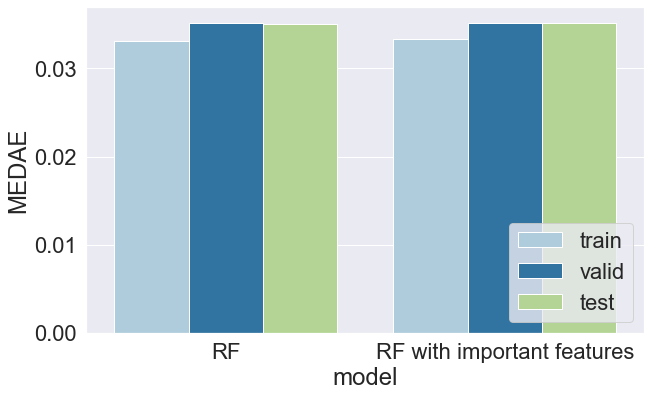

In [66]:
plt.figure(figsize=(10,6))
sns.set(font_scale=2)
plt_model_selection= sns.barplot(x="model", y='MEDAE', hue = 'flag', data=medae, palette='Paired')
plt.legend(loc=4)

MedAE on test set of Random Forest model(all features) is 0.0352.

MedAE on test set of Random Forest model(only important features) is 0.0351.

Using only important features does not improve the model much.

We are able to predict the finish placement of PUBG players in a match with an median error of about 3.5%.

## 7. Summary

- In order to predict the finish placement of the PUBG players, we fitted 3 models: linear regression without tuning as our baseline, decision tree and random forest, with hyperparameters tuned by RandomizedSearchCV.  
    
    
- Random forest model had the lowest MEDAE on the validation set. Decision tree worked very good on training dataset, but no as well on validation dataset, indicating it had the problem of overfiting. So we chose random forest model because the performance on training and validation datasets were comparable.   

   
- The random forest model had MEDAE of 0.035 on validation set, which means that we are able to predict the finish placement of PUBG players in a match with an median error of about 3.5%.
    
    
- The tuned random forest model selected about 10 important features out of 24. Top three important features include killPlace, that is the ranking of number of enemies killed by the player in a match, walkDistance, that is how far the player walked in a match and kills, that’s the number of enemies killed by the player.

## 8. Takeaways

#### (1) Technical key takeaways:

- Random forest improves generality.

- Feature engineering matters

#### (2) Non-technical key takeaways:


- The best killer wins!

- Walk around and explore more.

- Collect sufficient boosters boost yourself promptly.

- Kill from afar.